# 1. Notebook Setup

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

Import libraries

In [7]:
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest
from pmdarima.utils import tsdisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import eda as eda

# 2. Loading and Prepare data

Load CSV

In [8]:
df = pd.read_csv("../data/Folsom_irradiance.csv", infer_datetime_format=True)
df

,timeStamp,ghi,dni,dhi
0,2014-01-02 08:00:00,0.0,0.0,0.0
1,2014-01-02 08:01:00,0.0,0.0,0.0
2,2014-01-02 08:02:00,0.0,0.0,0.0
3,2014-01-02 08:03:00,0.0,0.0,0.0
4,2014-01-02 08:04:00,0.0,0.0,0.0
...,...,...,...,...
1552315,2016-12-31 07:55:00,0.0,0.0,0.0
1552316,2016-12-31 07:56:00,0.0,0.0,0.0
1552317,2016-12-31 07:57:00,0.0,0.0,0.0
1552318,2016-12-31 07:58:00,0.0,0.0,0.0


Convert `timeStamp` to a datetime and set as index

In [9]:
df["timeStamp"] = pd.to_datetime(df["timeStamp"])
df = df.set_index('timeStamp')

Drop other columns (only GHI needed for ARIMA)

In [10]:
df = df["ghi"]

Split train/test

In [11]:
# Split data into train and test based on the years
train_start = "2014-01-01"
validation_start = "2015-01-01"
test_start = "2016-01-01"

train_data = df.loc[df.index < validation_start]
validation_data = df.loc[(validation_start <= df.index) & (df.index < test_start)]
test_data = df.loc[df.index >= test_start]

Ensure no data leakage by checking date range of each sample created

In [12]:
eda.print_df_index_date_range(train_data, "Train")
eda.print_df_index_date_range(validation_data, "Validation")
eda.print_df_index_date_range(test_data, "Test")

Train dataset date ranges = 2014-01-02 08:00:00 to 2014-12-31 23:59:00

Validation dataset date ranges = 2015-01-01 00:00:00 to 2015-12-31 07:59:00

Test dataset date ranges = 2016-01-01 08:00:00 to 2016-12-31 07:59:00



Check for missing values in ghi

In [13]:
assert df.isnull().any() == False

# for c in ["ghi", "dni", "dhi"]:
#     df[c]=df[c].fillna(method='ffill')

Quickly visualise data

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


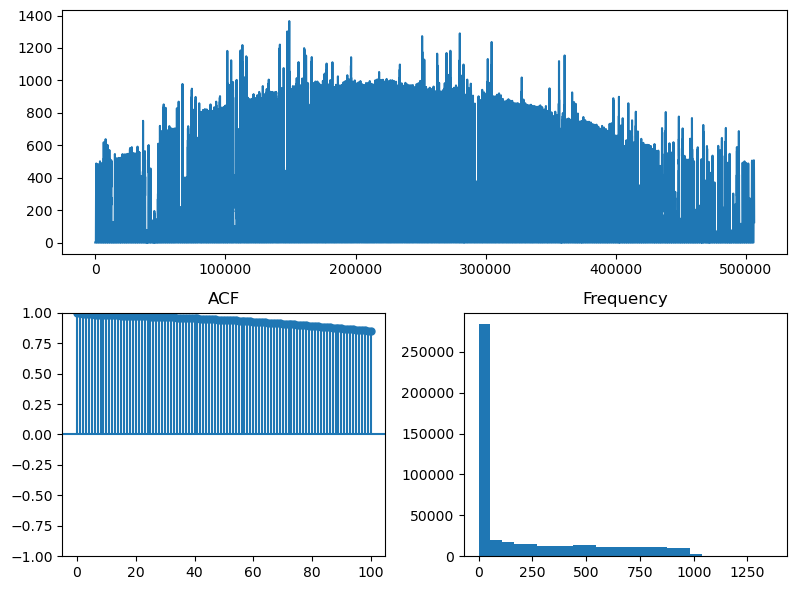

In [14]:
tsdisplay(train_data, lag_max=100)

Select data for a single day

In [31]:
train_day = train_data.loc[train_data.index < "2014-01-03"]
train_day

timeStamp
2014-01-02 08:00:00      0.0
2014-01-02 08:01:00      0.0
2014-01-02 08:02:00      0.0
2014-01-02 08:03:00      0.0
2014-01-02 08:04:00      0.0
                       ...  
2014-01-02 23:55:00    158.8
2014-01-02 23:56:00    150.5
2014-01-02 23:57:00    137.1
2014-01-02 23:58:00    119.0
2014-01-02 23:59:00    100.1
Name: ghi, Length: 960, dtype: float64

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


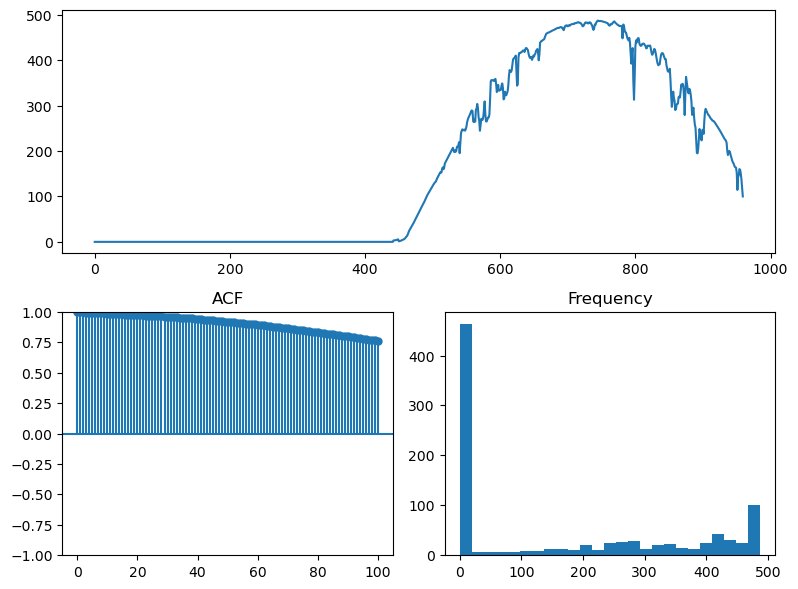

In [32]:
tsdisplay(train_day, lag_max=100)

Check if data is stationary over a day: **non-stationary**, will need to use at least a difference order of 1

Test for stationarity: Test whether we should difference at the alpha=0.05 significance level

In [33]:
def adf_test(timeseries):
    """https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/"""
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(train_day)

Results of Dickey-Fuller Test:
Test Statistic                  -0.913091
p-value                          0.783631
#Lags Used                      15.000000
Number of Observations Used    944.000000
Critical Value (1%)             -3.437296
Critical Value (5%)             -2.864607
Critical Value (10%)            -2.568403
dtype: float64


In [35]:
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(train_day)  # (0.01, False)

print(f"p_val = {p_val} (Should differentiate: {should_diff})")

p_val = 0.99 (Should differentiate: True)


Check autocorrelation

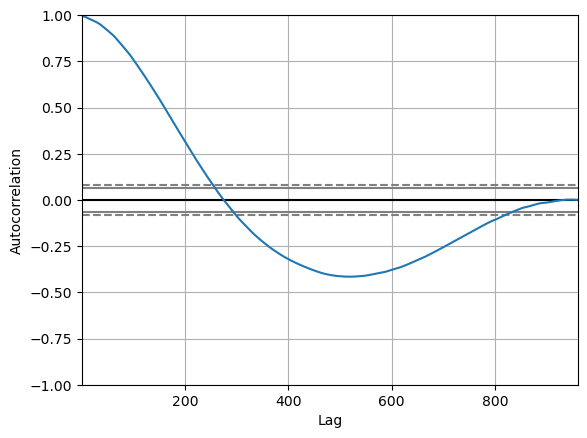

In [37]:
pd.plotting.autocorrelation_plot(train_day)
plt.show()

# 3. Train ARIMA Model

Set the frequency correctly by creating a new date range with a frequency of 'T' and then reindexing your data

In [38]:
# Create a new date range with frequency 'T'
date_range_train = pd.date_range(start=train_day.index[0], periods=len(train_data), freq='T')
# date_range_test = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='T')

# Set the new date range as the index for the data
train_data.index = date_range_train
# test_data.index = date_range_test

Fit ARIMA model (takes ~30 seconds)

In [40]:
model = ARIMA(train_day, order=(5, 1, 0))  # ARIMA print_df_index_date_range order
model_fit = model.fit()

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [42]:
model_fit.summary()

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1363: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    ghi   No. Observations:                  960
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3261.025
Date:                Wed, 30 Aug 2023   AIC                           6534.051
Time:                        16:46:50   BIC                           6563.246
Sample:                    01-02-2014   HQIC                          6545.170
                         - 01-02-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3580      0.013     27.708      0.000       0.333       0.383
ar.L2         -0.3433      0.017    -20.575      0.000      -0.376      -0.311
ar.L3          0.0077      0.017      0.452      0.652      -0.026       0.041
ar.L4          0.0272      0.025      1.090      0.276      -0.022       0.076
ar.L5          0.0064      0.022      0.289      0.772      -0.037       0.049
sigma2        52.5974      0.856     61.440      0.000      50.919      54.275
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             14952.12
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

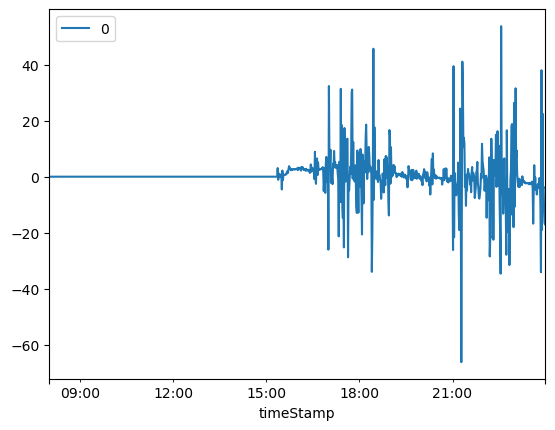

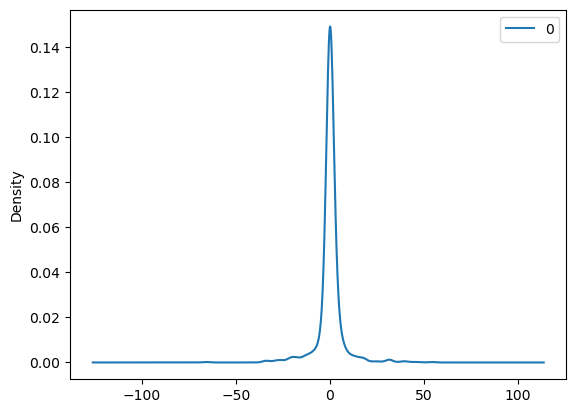

                0
count  960.000000
mean     0.102160
std      7.251670
min    -66.233742
25%      0.000000
50%      0.000000
75%      0.687368
max     53.771448


In [45]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

In [10]:
# model = pm.auto_arima(train_data['ghi'], 
#                       m=12, 
#                       seasonal=True,
#                       start_p=0, 
#                       start_q=0, 
#                       max_order=4, 
#                       test='adf',
#                       error_action='ignore',  
#                       suppress_warnings=True,
#                       stepwise=True, 
#                       trace=True)

Auto ARIMA

In [ ]:
# Find the best (p, d, q) values using auto_arima
MAX_ITER = 1
with pm.arima.StepwiseContext(max_dur=MAX_ITER):
    best_model = pm.auto_arima(train_data, 
                               m=1440, # 24x60x365.25 for daily data with annual seasonality
                               seasonal=True, 
                               suppress_warnings=True, 
                               stepwise=True,
                               # n_jobs=-1,
                               maxiter=MAX_ITER,
                               error_action='ignore',
                               random_state=42,
                               D=0)
    best_p, best_d, best_q = best_model.order

# # Fit the ARIMA model with the best (p, d, q) values
# model = ARIMA(train_data, order=(best_p, best_d, best_q))
# model_fit = model.fit()

# # Make predictions and plot
# forecast = model_fit.forecast(steps=len(test_data))
# prediction_df = pd.DataFrame(data=forecast, index=test_data.index, columns=['Prediction'])

# plt.figure(figsize=(12, 6))
# plt.plot(prediction_df['Prediction'], label='Prediction')
# plt.plot(test_data, label='Actual')
# plt.xlabel('Time')
# plt.ylabel('Solar Irradiance')
# plt.title('ARIMA Model Predictions vs Actual')
# plt.legend()
# plt.show()

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Grid Search

,"Params (p, d, q)",MAE,RMSE,R2


/tmp/ipykernel_27541/2462260793.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append({


,"Params (p, d, q)",MAE,RMSE,R2
0,0,0,0,0


In [29]:

df_gs = pd.DataFrame(columns=["Params (p, d, q)", "MAE", "RMSE", "R2"])

# Grid search for best (p, d, q) combination
best_mae = float('inf')
best_rmse = float('inf')
best_r2 = float('inf')

p_range = range(0, 6)
d_range = range(0, 2)
q_range = range(0, 6)

for p in p_range:
    for d in d_range:
        for q in q_range:
            print(f"Trying: {(p, d, q)}")
            model = ARIMA(train_data, order=(p, d, q))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(validation_data))
            
            mae = mean_absolute_error(validation_data, forecast)
            rmse = sqrt(mean_squared_error(validation_data, forecast))
            r2 = r2_score(validation_data, forecast)
            
            iter_results_dict = {"Params (p, d, q)": (p, d, q), "MAE": mae, "RMSE": rmse, "R2": r2}
            print(iter_results_dict)
            df_gs.append(iter_results_dict, ignore_index=True)

Trying: (0, 0, 0)
{'Params (p, d, q)': (0, 0, 0), 'MAE': 246.97520390922034, 'RMSE': 293.36623938238824, 'R2': -0.00010237767331955361}
Trying: (0, 0, 1)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Params (p, d, q)': (0, 0, 1), 'MAE': 246.97511621894193, 'RMSE': 293.3662223159979, 'R2': -0.00010226131271129368}
Trying: (0, 0, 2)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (0, 0, 2), 'MAE': 246.9750318820293, 'RMSE': 293.3662044347482, 'R2': -0.00010213939630565605}
Trying: (0, 0, 3)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (0, 0, 3), 'MAE': 246.97504083222353, 'RMSE': 293.36620620652724, 'R2': -0.00010215147649716982}
Trying: (0, 0, 4)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (0, 0, 4), 'MAE': 246.97484512102363, 'RMSE': 293.36617373749016, 'R2': -0.00010193009890580029}
Trying: (0, 0, 5)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (0, 0, 5), 'MAE': 246.97489072963236, 'RMSE': 293.366177445155, 'R2': -0.00010195537818580291}
Trying: (0, 1, 0)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (0, 1, 0), 'MAE': 223.88958522553511, 'RMSE': 304.79576077132856, 'R2': -0.07954819857091433}
Trying: (0, 1, 1)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (0, 1, 1), 'MAE': 223.87543510837622, 'RMSE': 304.8136564298194, 'R2': -0.07967497062960605}
Trying: (0, 1, 2)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (0, 1, 2), 'MAE': 224.83842039715907, 'RMSE': 303.6426428026891, 'R2': -0.07139525286568826}
Trying: (0, 1, 3)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (0, 1, 3), 'MAE': 225.9937812483241, 'RMSE': 302.35375795387415, 'R2': -0.06231896303729356}
Trying: (0, 1, 4)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (0, 1, 4), 'MAE': 226.75355492644903, 'RMSE': 301.57011026742407, 'R2': -0.0568194119313683}
Trying: (0, 1, 5)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (0, 1, 5), 'MAE': 227.4629951440564, 'RMSE': 300.8815141711326, 'R2': -0.051998702796907104}
Trying: (1, 0, 0)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (1, 0, 0), 'MAE': 246.93512289732325, 'RMSE': 293.3413119225779, 'R2': 6.757339344953817e-05}
Trying: (1, 0, 1)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (1, 0, 1), 'MAE': 246.93587235246352, 'RMSE': 293.34178830312607, 'R2': 6.432564944014452e-05}
Trying: (1, 0, 2)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (1, 0, 2), 'MAE': 246.9158688796584, 'RMSE': 293.32924990563015, 'R2': 0.00014980493337590772}
Trying: (1, 0, 3)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (1, 0, 3), 'MAE': 246.90799214079308, 'RMSE': 293.3242708095755, 'R2': 0.00018374841436707978}
Trying: (1, 0, 4)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (1, 0, 4), 'MAE': 246.90169622367355, 'RMSE': 293.3203478410554, 'R2': 0.0002104916595926376}
Trying: (1, 0, 5)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (1, 0, 5), 'MAE': 246.89510920780523, 'RMSE': 293.31623782287386, 'R2': 0.00023850965628779974}
Trying: (1, 1, 0)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (1, 1, 0), 'MAE': 223.87960665272183, 'RMSE': 304.808379305127, 'R2': -0.07963758693627687}
Trying: (1, 1, 1)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (1, 1, 1), 'MAE': 229.15298925151913, 'RMSE': 299.3981096345715, 'R2': -0.04165115605520153}
Trying: (1, 1, 2)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (1, 1, 2), 'MAE': 228.54605794757396, 'RMSE': 299.9064328780909, 'R2': -0.045191225083510034}
Trying: (1, 1, 3)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (1, 1, 3), 'MAE': 228.60049627696506, 'RMSE': 299.8597402871497, 'R2': -0.04486579767068788}
Trying: (1, 1, 4)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (1, 1, 4), 'MAE': 228.7050828354139, 'RMSE': 299.7706499055505, 'R2': -0.04424501634085898}
Trying: (1, 1, 5)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (1, 1, 5), 'MAE': 228.6920052720265, 'RMSE': 299.78174799900916, 'R2': -0.04432233774183558}
Trying: (2, 0, 0)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (2, 0, 0), 'MAE': 246.9357834840207, 'RMSE': 293.34173137168455, 'R2': 6.47137821652155e-05}
Trying: (2, 0, 1)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Params (p, d, q)': (2, 0, 1), 'MAE': 246.93748574198, 'RMSE': 293.3428153063903, 'R2': 5.732399444058345e-05}
Trying: (2, 0, 2)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (2, 0, 2), 'MAE': 246.8781596242099, 'RMSE': 293.30609908668134, 'R2': 0.00030762374895354494}
Trying: (2, 0, 3)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (2, 0, 3), 'MAE': 246.8778203608302, 'RMSE': 293.30578046439416, 'R2': 0.0003097957058226797}
Trying: (2, 0, 4)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (2, 0, 4), 'MAE': 246.87722123570026, 'RMSE': 293.3055166322408, 'R2': 0.00031159417225790076}
Trying: (2, 0, 5)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (2, 0, 5), 'MAE': 246.8928965367716, 'RMSE': 293.3146154608456, 'R2': 0.00024956919125007637}
Trying: (2, 1, 0)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (2, 1, 0), 'MAE': 224.4536729715472, 'RMSE': 304.09942934970303, 'R2': -0.07462119668286249}
Trying: (2, 1, 1)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (2, 1, 1), 'MAE': 228.35696172137628, 'RMSE': 300.07027983127387, 'R2': -0.046333569218663495}
Trying: (2, 1, 2)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (2, 1, 2), 'MAE': 228.58360989576332, 'RMSE': 299.8742008488087, 'R2': -0.044966576191991514}
Trying: (2, 1, 3)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (2, 1, 3), 'MAE': 228.49991337067328, 'RMSE': 299.94618295573486, 'R2': -0.045468306073513265}
Trying: (2, 1, 4)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Params (p, d, q)': (2, 1, 4), 'MAE': 228.6940024096951, 'RMSE': 299.78005109190514, 'R2': -0.04431051505422934}
Trying: (2, 1, 5)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (2, 1, 5), 'MAE': 228.6888472565049, 'RMSE': 299.7844288541995, 'R2': -0.04434101592685891}
Trying: (3, 0, 0)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (3, 0, 0), 'MAE': 246.92485434490993, 'RMSE': 293.3348012304568, 'R2': 0.00011195977654465672}
Trying: (3, 0, 1)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Params (p, d, q)': (3, 0, 1), 'MAE': 246.91833980259685, 'RMSE': 293.33025749505157, 'R2': 0.00014293592723224613}
Trying: (3, 0, 2)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (3, 0, 2), 'MAE': 246.9010945770564, 'RMSE': 293.3196262237115, 'R2': 0.00021541095392285659}
Trying: (3, 0, 3)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (3, 0, 3), 'MAE': 246.87917052336496, 'RMSE': 293.3063069027843, 'R2': 0.000306207124832536}
Trying: (3, 0, 4)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (3, 0, 4), 'MAE': 246.89392889989864, 'RMSE': 293.3152635788945, 'R2': 0.00024515102058730864}
Trying: (3, 0, 5)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (3, 0, 5), 'MAE': 246.82868468698877, 'RMSE': 293.2752948625121, 'R2': 0.0005175964093108165}
Trying: (3, 1, 0)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (3, 1, 0), 'MAE': 224.75535396958594, 'RMSE': 303.7400510051009, 'R2': -0.07208276779708278}
Trying: (3, 1, 1)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Params (p, d, q)': (3, 1, 1), 'MAE': 228.69143508062143, 'RMSE': 299.7822307301607, 'R2': -0.04432570103752598}
Trying: (3, 1, 2)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Params (p, d, q)': (3, 1, 2), 'MAE': 228.70576601169282, 'RMSE': 299.77007094011975, 'R2': -0.044240982715939126}
Trying: (3, 1, 3)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (3, 1, 3), 'MAE': 228.67760997967105, 'RMSE': 299.79397605965084, 'R2': -0.0444075350389006}
Trying: (3, 1, 4)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (3, 1, 4), 'MAE': 228.5905284033008, 'RMSE': 299.86827418178814, 'R2': -0.044925271486706775}
Trying: (3, 1, 5)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Params (p, d, q)': (3, 1, 5), 'MAE': 225.63770943542298, 'RMSE': 302.73854785416745, 'R2': -0.06502459977581743}
Trying: (4, 0, 0)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (4, 0, 0), 'MAE': 246.91761454229604, 'RMSE': 293.33030037312, 'R2': 0.00014264361546667548}
Trying: (4, 0, 1)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (4, 0, 1), 'MAE': 246.87805592661294, 'RMSE': 293.30565756997885, 'R2': 0.00031063344122128633}
Trying: (4, 0, 2)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Params (p, d, q)': (4, 0, 2), 'MAE': 246.87922482248675, 'RMSE': 293.30640383784106, 'R2': 0.0003055463453791596}
Trying: (4, 0, 3)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (4, 0, 3), 'MAE': 246.8965242421757, 'RMSE': 293.3168326386133, 'R2': 0.00023445482129114126}
Trying: (4, 0, 4)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (4, 0, 4), 'MAE': 246.8690081124377, 'RMSE': 293.3001036462481, 'R2': 0.0003484925536239025}
Trying: (4, 0, 5)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (4, 0, 5), 'MAE': 246.8854942644782, 'RMSE': 293.31010631894037, 'R2': 0.00028030739298756657}
Trying: (4, 1, 0)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (4, 1, 0), 'MAE': 224.96991377927782, 'RMSE': 303.48977464713465, 'R2': -0.07031674171334568}
Trying: (4, 1, 1)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Params (p, d, q)': (4, 1, 2), 'MAE': 228.7224067767716, 'RMSE': 299.7559692838396, 'R2': -0.04414273954570036}
Trying: (4, 1, 3)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (4, 1, 3), 'MAE': 228.72101818707588, 'RMSE': 299.757145718704, 'R2': -0.04415093533466563}
Trying: (4, 1, 4)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Params (p, d, q)': (4, 1, 4), 'MAE': 228.71388751450377, 'RMSE': 299.76318714291943, 'R2': -0.04419302422164595}
Trying: (4, 1, 5)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (4, 1, 5), 'MAE': 228.65924054904116, 'RMSE': 299.8096032065587, 'R2': -0.044516420051039285}
Trying: (5, 0, 0)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (5, 0, 0), 'MAE': 246.91288067010643, 'RMSE': 293.32738929339075, 'R2': 0.00016248916183903006}
Trying: (5, 0, 1)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Params (p, d, q)': (5, 0, 1), 'MAE': 242.6795152691587, 'RMSE': 291.6522947934302, 'R2': 0.011549357224635015}
Trying: (5, 0, 2)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Params (p, d, q)': (5, 0, 2), 'MAE': 246.86599763240352, 'RMSE': 293.29843870754894, 'R2': 0.0003598417058119363}
Trying: (5, 0, 3)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (5, 0, 3), 'MAE': 246.89236910783208, 'RMSE': 293.3143258832569, 'R2': 0.00025154321614262454}
Trying: (5, 0, 4)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Params (p, d, q)': (5, 0, 4), 'MAE': 246.86038127745118, 'RMSE': 293.29479947580893, 'R2': 0.0003846485178704562}
Trying: (5, 0, 5)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (5, 0, 5), 'MAE': 246.86536462860917, 'RMSE': 293.2978417551181, 'R2': 0.00036391085134013235}
Trying: (5, 1, 0)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (5, 1, 0), 'MAE': 225.2830722670567, 'RMSE': 303.132169631129, 'R2': -0.0677958980601554}
Trying: (5, 1, 1)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Params (p, d, q)': (5, 1, 1), 'MAE': 228.66992263240994, 'RMSE': 299.8005146729777, 'R2': -0.04445309333588998}
Trying: (5, 1, 2)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (5, 1, 2), 'MAE': 228.71088187930252, 'RMSE': 299.7657338443093, 'R2': -0.044210766621221476}
Trying: (5, 1, 3)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (5, 1, 3), 'MAE': 228.68669886905843, 'RMSE': 299.7862534154554, 'R2': -0.04435372819454697}
Trying: (5, 1, 4)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Params (p, d, q)': (5, 1, 4), 'MAE': 228.6308267663966, 'RMSE': 299.8338229295237, 'R2': -0.0446851866274538}
Trying: (5, 1, 5)


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


{'Params (p, d, q)': (5, 1, 5), 'MAE': 228.71344999048492, 'RMSE': 299.763557560028, 'R2': -0.04419560484005669}


/tmp/ipykernel_27541/576037720.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gs.append(iter_results_dict, ignore_index=True)


# 4. Make Forecasting Predictions

Loop through each minute prediction from 1 to 20, forecasts the next minute step using the ARIMA model, stores the forecasted values in a DataFrame, calculates the errors at each minute prediction, and plots the mean absolute error at each forecast horizon.

In [22]:
forecast_horizon = 20

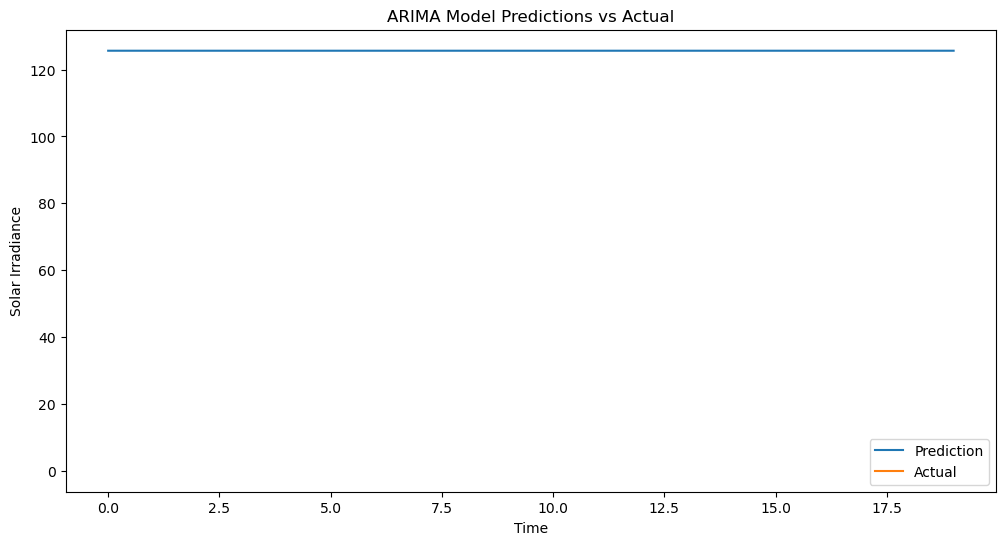

In [21]:
# Initialize an empty array to store forecasted values
forecast_values = []

# Break down the predictions into smaller chunks to manage memory
chunk_size = 10000
num_chunks = len(test_data) // chunk_size + 1

for chunk_idx in range(num_chunks):
    start_idx = chunk_idx * chunk_size
    end_idx = min((chunk_idx + 1) * chunk_size, len(test_data))
    chunk_forecast_series = model_fit.forecast(steps=(end_idx - start_idx) * forecast_horizon)
    chunk_forecast_array = np.array(chunk_forecast_series).reshape(-1, forecast_horizon)
    forecast_values.append(chunk_forecast_array)

# Concatenate the chunks to get the complete forecast values
forecast_values = np.concatenate(forecast_values)

# Create a DataFrame to store predictions
prediction_index = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='T')
prediction_df = pd.DataFrame(data=forecast_values, index=prediction_index)

In [23]:
prediction_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2016-01-01 08:00:00,125.653878,125.653530,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527
2016-01-01 08:01:00,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527
2016-01-01 08:02:00,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527
2016-01-01 08:03:00,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527
2016-01-01 08:04:00,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-29 07:55:00,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527
2016-12-29 07:56:00,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527
2016-12-29 07:57:00,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527
2016-12-29 07:58:00,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527,125.653527


In [37]:
prediction_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,522720.000000,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05,5.227200e+05
mean,125.653527,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02
std,0.000004,2.675070e-08,2.022605e-10,1.532630e-12,8.616497e-14,8.526677e-14,8.526521e-14,8.526521e-14,8.526521e-14,8.526521e-14,8.526521e-14,8.526521e-14,8.526521e-14,8.526521e-14,8.526521e-14,8.526521e-14,8.526521e-14,8.526521e-14,8.526521e-14,8.526521e-14
min,125.653527,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02
25%,125.653527,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02
50%,125.653527,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02
75%,125.653527,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02
max,125.653878,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02,1.256535e+02


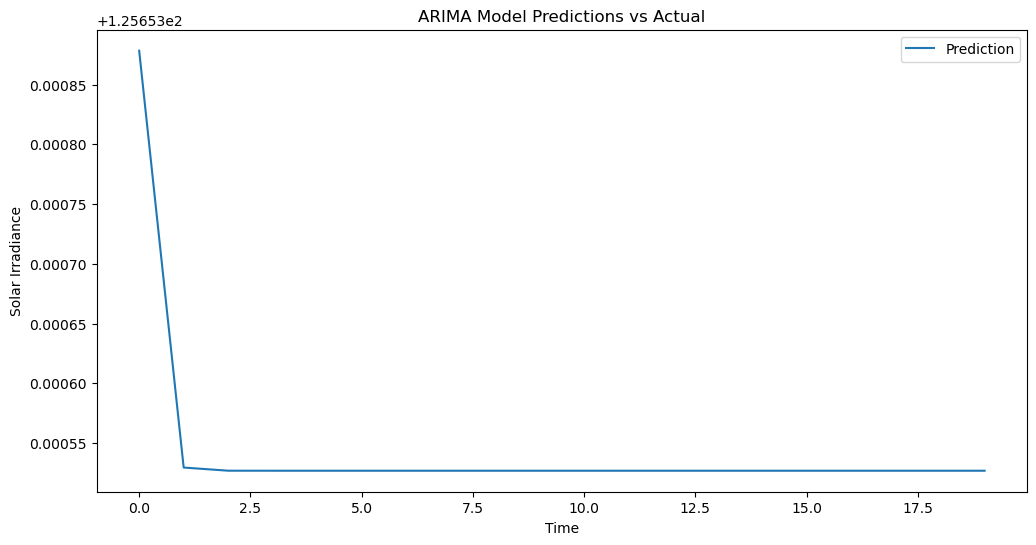

In [35]:
# Plot the predicted values for the first instance
plt.figure(figsize=(12, 6))
plt.plot(prediction_df.iloc[0], label='Prediction')
# plt.plot(test_data.iloc[0], label='Actual')
plt.xlabel('Time')
plt.ylabel('Solar Irradiance')
plt.title('ARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

___

In [ ]:
forecast_values = model_fit.forecast(steps=len(test_data) * FORECASTING_HORIZON).reshape(-1, FORECASTING_HORIZON)

In [ ]:
# Predict the entire forecast horizon for all instances
forecast_values = model_fit.forecast(steps=len(test_data) * FORECASTING_HORIZON).reshape(-1, FORECASTING_HORIZON)

# Create a DataFrame to store predictions
prediction_index = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='T')
prediction_df = pd.DataFrame(data=forecast_values, index=prediction_index)

# Plot the predicted values for the first instance
plt.figure(figsize=(12, 6))
plt.plot(prediction_df.iloc[0], label='Prediction')
plt.plot(test_data.iloc[0], label='Actual')
plt.xlabel('Time')
plt.ylabel('Solar Irradiance')
plt.title('ARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

Loop through each minute prediction from 1 to 20

In [22]:
len(test_data)

522720

In [ ]:
# Initialize an empty DataFrame to store forecasted values
forecast_values = np.empty((len(test_data), FORECASTING_HORIZON))

# Loop through each minute prediction from 1 to 20
for idx in range(len(test_data)):
    forecast = model_fit.forecast(steps=FORECASTING_HORIZON)
    forecast_values[idx, :] = forecast

Calculate and plot the errors at each minute prediction

In [27]:
errors = np.abs(forecast_values - test_data.values.reshape(-1, 1))
mean_errors = errors.mean(axis=0)

ValueError: Unable to coerce to DataFrame, shape must be (522720, 20): given (1568160, 1)

In [ ]:


plt.figure(figsize=(10, 6))
plt.plot(mean_errors, marker='o')
plt.xlabel('Forecast Horizon (Minutes)')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error at Each Forecast Horizon')
plt.xticks(range(1, FORECASTING_HORIZON + 1))
plt.grid(True)
plt.show()